In [154]:
import time
from concurrent.futures import ThreadPoolExecutor, as_completed

from torch_geometric.utils import subgraph


import networkx as nx
import torch
from torch_geometric.data import Data
from torch_geometric.utils import degree

from custom.utils import *

In [155]:
def create_subgraphs(pattern, graph1, graph2):
    g1_nodes = set()
    g2_nodes = set()
    for g1_node, g2_node in pattern.items():
        g1_nodes.add(g1_node)
        g2_nodes.add(g2_node)

    g1_node_map = {node: idx for idx, node in enumerate(g1_nodes)}
    g2_node_map = {node: idx for idx, node in enumerate(g2_nodes)}

    g1_edge_index = []
    for edge in graph1.edge_index.t():
        if edge[0].item() in g1_nodes and edge[1].item() in g1_nodes:
            g1_edge_index.append(
                [g1_node_map[edge[0].item()], g1_node_map[edge[1].item()]]
            )

    g2_edge_index = []
    for edge in graph2.edge_index.t():
        if edge[0].item() in g2_nodes and edge[1].item() in g2_nodes:
            g2_edge_index.append(
                [g2_node_map[edge[0].item()], g2_node_map[edge[1].item()]]
            )

    g1_subgraph = Data(
        x=graph1.x[list(g1_nodes)],
        edge_index=torch.tensor(g1_edge_index, dtype=torch.long).t().contiguous(),
        original_node_ids=torch.tensor(list(g1_nodes), dtype=torch.long),
    )
    g2_subgraph = Data(
        x=graph2.x[list(g2_nodes)],
        edge_index=torch.tensor(g2_edge_index, dtype=torch.long).t().contiguous(),
        original_node_ids=torch.tensor(list(g2_nodes), dtype=torch.long),
    )

    return g1_subgraph, g2_subgraph

In [156]:
def mutual_pairs(attention_nodes, i=0):
    outer_layer = attention_nodes[i]
    g1_attention, g2_attention = outer_layer

    mutual_pairs = []

    for g1_node, g1_attends in enumerate(g1_attention):
        for g2_node in g1_attends:
            if g1_node in g2_attention[g2_node]:
                pair = (g1_node, g2_node)
                if pair not in mutual_pairs:
                    mutual_pairs.append(pair)

    random.shuffle(mutual_pairs)
    return mutual_pairs


def print_patterns(patterns, graph1, graph2):
    for i in patterns:
        g1_subgraph, g2_subgraph = create_subgraphs(i, graph1, graph2)

        if nx.is_isomorphic(
            to_networkx(g1_subgraph, to_undirected=True),
            to_networkx(g2_subgraph, to_undirected=True),
        ):

            plot_mutag(
                g1_subgraph,
                g2_subgraph,
                perm1=g1_subgraph.original_node_ids,
                perm2=g2_subgraph.original_node_ids,
            )


def create_subgraph(data, node_set):
    """
    Create a subgraph from the original graph that only contains the nodes in the node_set.

    Parameters:
    data (torch_geometric.data.Data): The original graph data.
    node_set (set or list): The set of nodes to include in the subgraph.

    Returns:
    torch_geometric.data.Data: The subgraph containing only the nodes in node_set.
    """
    # Convert the node_set to a tensor
    node_mask = torch.tensor(list(node_set), dtype=torch.long)

    # Create the subgraph
    edge_index, edge_mask = subgraph(node_mask, data.edge_index, relabel_nodes=True)

    # Filter node features (x) and other attributes if present
    x = data.x[node_mask] if data.x is not None else None
    edge_attr = data.edge_attr[edge_mask] if data.edge_attr is not None else None

    # Create new graph data with the subgraph
    sub_data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

    return sub_data

In [157]:
import networkx as nx
import torch
from torch_geometric.utils import degree
import time


class VF2MCES:
    def __init__(self, mp):
        self.mp = mp
        self.start_time = None
        self.max_size = 0
        self.all_mappings = []
        self.unique_mappings = set()

    def find_mces(self, G1, G2):
        self.max_size = 0
        self.all_mappings = []
        self.unique_mappings = set()
        self.start_time = time.time()

        G1_degrees = degree(G1.edge_index[0], G1.num_nodes)
        G2_degrees = degree(G2.edge_index[0], G2.num_nodes)

        nodes1 = list(range(G1.num_nodes))
        nodes2 = list(range(G2.num_nodes))

        for n1 in nodes1:
            for n2 in nodes2:
                if (n1, n2) in self.mp:
                    M = {n1: n2}
                    neighbors1 = set(G1.edge_index[1][G1.edge_index[0] == n1].tolist())
                    neighbors2 = set(G2.edge_index[1][G2.edge_index[0] == n2].tolist())
                    self.match(
                        G1, G2, M, G1_degrees, G2_degrees, neighbors1, neighbors2
                    )
        return self.all_mappings

    def match(self, G1, G2, M, G1_degrees, G2_degrees, neighbors1, neighbors2):
        if len(M) > self.max_size:
            self.max_size = len(M)
            self.all_mappings = [M.copy()]
            self.unique_mappings = {self.canonical_form(M)}
        elif len(M) == self.max_size:
            canonical = self.canonical_form(M)
            if canonical not in self.unique_mappings:
                self.all_mappings.append(M.copy())
                self.unique_mappings.add(canonical)

        candidates1 = sorted(neighbors1, key=lambda n: -G1_degrees[n].item())
        candidates2 = sorted(neighbors2, key=lambda n: -G2_degrees[n].item())

        for n1 in candidates1:
            if n1 not in M:
                for n2 in candidates2:
                    if n2 not in M.values() and self.feasible(
                        n1, n2, M, G1, G2, G1_degrees, G2_degrees
                    ):
                        M[n1] = n2
                        new_neighbors1 = set(
                            G1.edge_index[1][G1.edge_index[0] == n1].tolist()
                        )
                        new_neighbors2 = set(
                            G2.edge_index[1][G2.edge_index[0] == n2].tolist()
                        )
                        neighbors1.update(new_neighbors1 - set(M.keys()))
                        neighbors2.update(new_neighbors2 - set(M.values()))
                        self.match(
                            G1,
                            G2,
                            M,
                            G1_degrees,
                            G2_degrees,
                            neighbors1,
                            neighbors2,
                        )
                        del M[n1]
                        neighbors1.difference_update(new_neighbors1)
                        neighbors2.difference_update(new_neighbors2)

    def feasible(self, n1, n2, M, G1, G2, G1_degrees, G2_degrees):
        if not torch.equal(G1.x[n1], G2.x[n2]):
            return False
        if (n1, n2) not in self.mp:
            return False

        count1 = 0
        count2 = 0

        for neighbor in G1.edge_index[1][G1.edge_index[0] == n1]:
            if neighbor.item() in M:
                count1 += 1

        for neighbor in G2.edge_index[1][G2.edge_index[0] == n2]:
            if neighbor.item() in M.values():
                count2 += 1

        if count1 != count2:
            return False

        for neighbor in G1.edge_index[1][G1.edge_index[0] == n1]:
            if (
                neighbor.item() in M
                and not (
                    G2.edge_index[1][G2.edge_index[0] == n2] == M[neighbor.item()]
                ).any()
            ):
                return False

        if not self.is_connected_subgraph(M, G1) or not self.is_connected_subgraph(
            M, G2, reverse=True
        ):
            return False

        return True

    def is_connected_subgraph(self, M, G, reverse=False):
        if reverse:
            subgraph_nodes = set(M.values())
            edge_index = G.edge_index
        else:
            subgraph_nodes = set(M.keys())
            edge_index = G.edge_index

        if len(subgraph_nodes) < 2:
            return True

        subgraph_edges = [
            (u.item(), v.item())
            for u, v in zip(edge_index[0], edge_index[1])
            if u.item() in subgraph_nodes and v.item() in subgraph_nodes
        ]

        if not subgraph_edges:
            return False

        subgraph = nx.Graph(subgraph_edges)
        return nx.is_connected(subgraph)

    def canonical_form(self, M):
        G1_set = set(M.keys())
        G2_set = set(M.values())
        return (frozenset(G1_set), frozenset(G2_set))

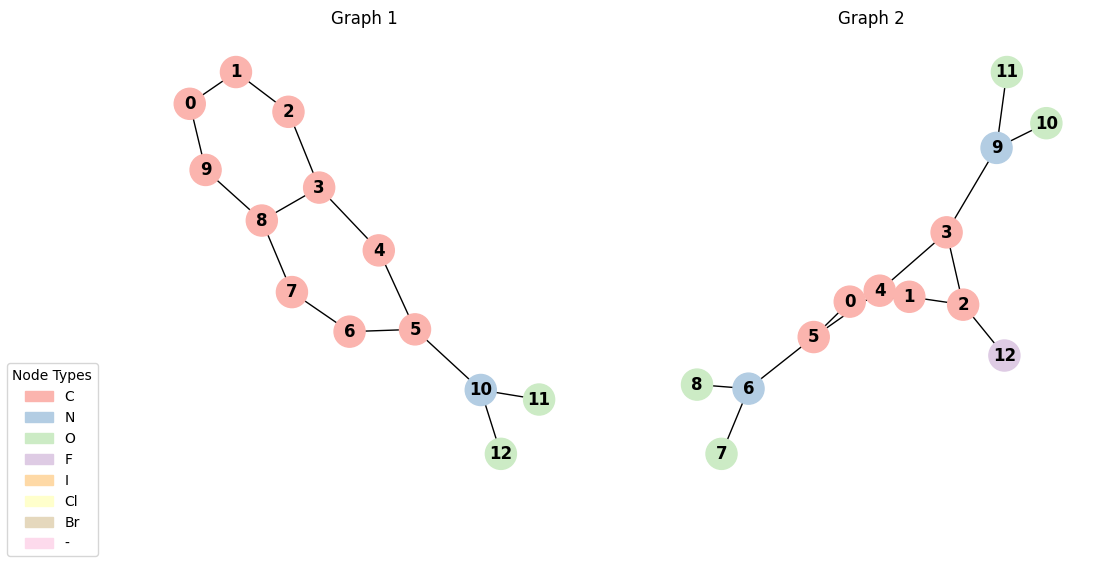

In [158]:
(graph1, graph2, attention_nodes) = torch.load("info.pt")
mp_0 = mutual_pairs(attention_nodes, 1)

vf2 = VF2MCES(mp_0)

plot_mutag(graph1, graph2)

Largest Common Subgraph Mapping: [{3: 3, 8: 2, 4: 4, 5: 5, 10: 6, 6: 0, 7: 1, 11: 7, 12: 8}]
Time taken: 0.6306412220001221 seconds


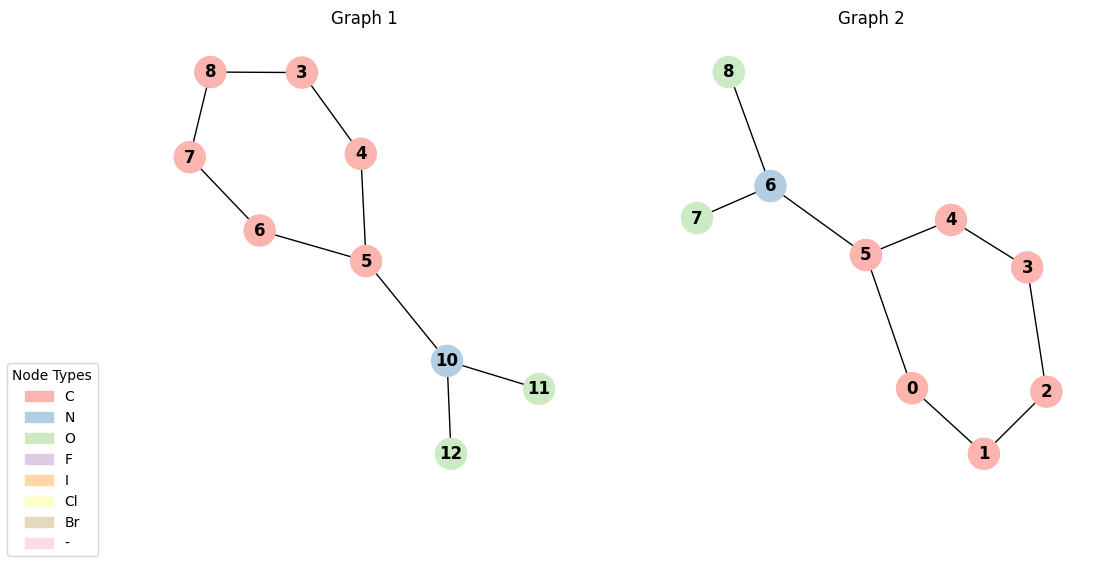

In [159]:
start_time = time.time()
mcs = vf2.find_mces(graph1, graph2)
end_time = time.time()

print("Largest Common Subgraph Mapping:", mcs)
print("Time taken:", end_time - start_time, "seconds")
print_patterns(mcs, graph1, graph2)

In [160]:
print_patterns([mcs[3]], graph1, graph2)

IndexError: list index out of range

In [ ]:
mcs_0 = mcs[0]
mcs_1 = mcs[1]

print(sorted(mcs_0.keys()))
print(sorted(mcs_0.values()))

[3, 4, 5, 6, 7, 8, 10, 11, 12]
[0, 1, 2, 3, 4, 5, 6, 7, 8]


In [ ]:
nodes_1 = []
nodes_2 = []
for m in mcs:
    nodes_1.extend(list(m.keys()))
    nodes_2.extend(list(m.values()))

nodes_1 = set(nodes_1)
nodes_2 = set(nodes_2)

print(nodes_1, nodes_2)

mp_1 = mutual_pairs(attention_nodes, 1)

for n1, n2 in mp_1:
    if n1 in nodes_1:
        mp_1.remove((n1, n2))

for n1, n2 in mp_1:
    if n2 in nodes_2:
        mp_1.remove((n1, n2))

print(sorted(mp_1))

{0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12} {0, 1, 2, 3, 4, 5, 6, 7, 8}
[(1, 4), (3, 3), (4, 4), (5, 2), (5, 3), (6, 0), (7, 1), (9, 1), (11, 10), (12, 8), (12, 10)]


In [ ]:
vf2 = VF2MCES(mp_1, time_limit=60)
start_time = time.time()
mcs = vf2.find_mces(graph1, graph2)
end_time = time.time()

print("Largest Common Subgraph Mapping:", mcs)
print("Time taken:", end_time - start_time, "seconds")

Largest Common Subgraph Mapping: [{3: 3, 4: 4}, {4: 4, 5: 3}, {6: 0, 7: 1}]
Time taken: 0.0025930404663085938 seconds


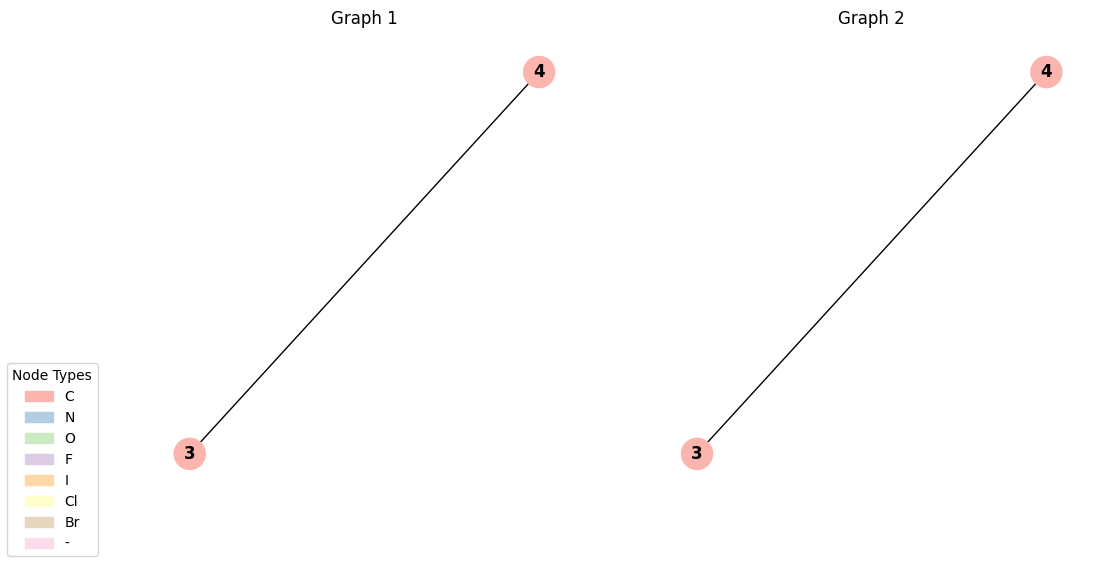

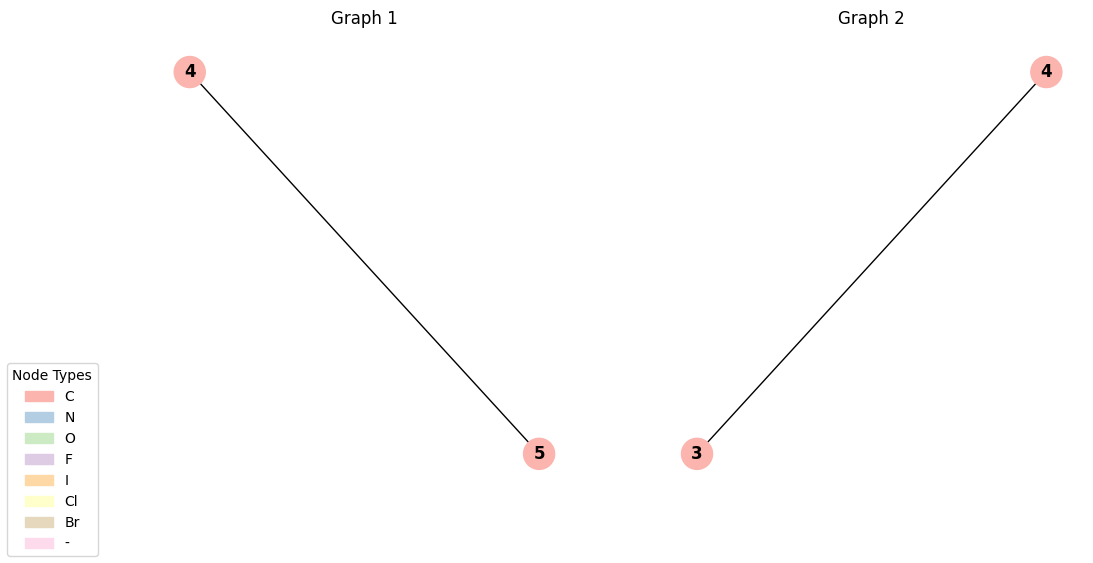

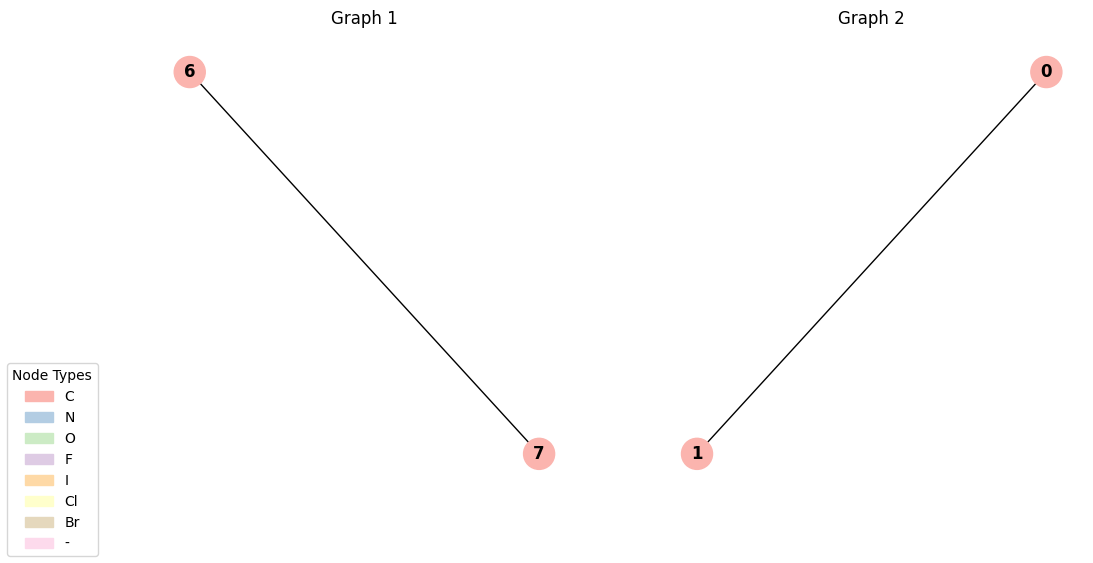

[{3: 3, 4: 4}, {4: 4, 5: 3}, {6: 0, 7: 1}]


In [ ]:
print_patterns(mcs, graph1, graph2)
print(mcs)